In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import model_functions as mf
import feature_eng as fe
import importlib
importlib.reload(mf)
importlib.reload(fe)

<module 'feature_eng' from '/Users/yorkmacbook020/Documents/york/jenny-huang/jenny-huang-aml-student-regression/feature_eng.py'>

In [3]:
X =fe.X_no_grades
y = fe.y
X_train, X_test, y_train, y_test = fe.split_transform(X, y, fe.ord_trans)

In [4]:
#models and selectors 
models = [SVR(), RandomForestRegressor(), Ridge(), KNeighborsRegressor(), GradientBoostingRegressor()]
selectors = [SelectKBest(k = i, score_func = mutual_info_regression) for i in range (3, len(X_train.columns)+1)]

In [5]:
params = {"SVR()": {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], #SVR
          'gamma' : [10**x/10000 for x in range (3)],
          'C' : [10**x/100 for x in range (0,3)]},
          "RandomForestRegressor()": {'n_estimators' : range(10, 160, 10),     #Random Forest
           'max_features' : ['sqrt', 'log2', None]
          },
          "Ridge()": {'alpha' : [10**x/100000 for x in range(0, 10,2)]  #Ridge
          },
          "KNeighborsRegressor()": {'n_neighbors' : range(2,21),     #KNeighbors
           'weights'  : ['uniform', 'distance']     
          },
          "GradientBoostingRegressor()": {
            'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],  #Gradient Boosting
            'n_estimators' : range(10, 160, 10)
          }
}

In [6]:
best_features = mf.compare_models(models, X_train, X_test, y_train, y_test, selectors, 'relative error')


In [7]:
best_features.head(6)

,model,k features,features,r2,mse,mae,relative error
0,GradientBoostingRegressor(),25,"[Mjob, Fjob, guardian, sex, address, Medu, stu...",0.282515,15.263158,3.052632,0.274882
1,RandomForestRegressor(),24,"[Mjob, Fjob, school, age, address, famsize, Me...",0.240950,16.147368,3.094737,0.278673
2,KNeighborsRegressor(),22,"[Mjob, guardian, sex, age, address, famsize, M...",0.142481,18.242105,3.147368,0.283412
3,Ridge(),10,"[Fjob, guardian, address, Medu, traveltime, fa...",0.130111,18.505263,3.263158,0.293839
4,SVR(),22,"[Mjob, reason, address, Medu, Fedu, traveltime...",0.082608,19.515789,3.284211,0.295735


In [8]:
#tune hyperparameters for top 3 models
stats = {}
for i in (best_features.index[:3]): 
    model = eval(best_features.iloc[i]['model'])
    features = best_features.iloc[i]['features']
    hps = params[best_features.iloc[i]['model']]
    results = mf.tune_model(model, X_train[features], y_train, hps)
    print(f"doing {model}")
    stats[(str(model), str(features))] = results

doing GradientBoostingRegressor()
doing RandomForestRegressor()
doing KNeighborsRegressor()


In [9]:
#apply tuned hyperparameters 
tuned_stats = pd.DataFrame(columns = ['model', 'params','n','features', 'r2', 'mse', 'mae', 'relative error'])
for k,v in stats.items():
    params = v['params'][0]
    features = eval(k[1])
    model = eval(k[0][:-2])(**params)
    model.fit(X_train[features], y_train)
    pred = model.predict(X_test[features])
    r2 = r2_score(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    relative_e = mae/y_test.mean()
    tuned_stats.loc[len(tuned_stats.index)] = [k[0], params, len(features), features, r2, mse, mae, relative_e]

In [10]:
tuned_stats['summary'] = [f"{tuned_stats.iloc[i]['model']}:\n{tuned_stats.iloc[i]['params']}\n features: {tuned_stats.iloc[i]['features'] if len(tuned_stats.iloc[i]['features'])<10 else len(tuned_stats.iloc[i]['features'])}" for i in tuned_stats.index]
tuned_stats.head(6)


,model,params,n,features,r2,mse,mae,relative error,summary
0,GradientBoostingRegressor(),"{'loss': 'squared_error', 'n_estimators': 10}",25,"[Mjob, Fjob, guardian, sex, address, Medu, stu...",0.184754,17.342830,3.276338,0.295026,GradientBoostingRegressor():\n{'loss': 'square...
1,RandomForestRegressor(),"{'max_features': 'sqrt', 'n_estimators': 10}",24,"[Mjob, Fjob, school, age, address, famsize, Me...",0.117686,18.769579,3.352632,0.301896,RandomForestRegressor():\n{'max_features': 'sq...
2,KNeighborsRegressor(),"{'n_neighbors': 2, 'weights': 'uniform'}",22,"[Mjob, guardian, sex, age, address, famsize, M...",-0.091320,23.215789,3.652632,0.328910,"KNeighborsRegressor():\n{'n_neighbors': 2, 'we..."


/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_57119/3786608995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))


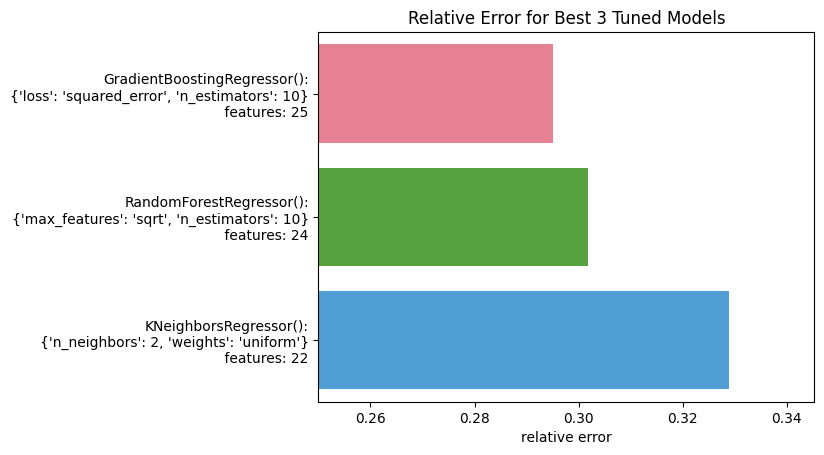

In [11]:
#relative error for tuned
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['relative error'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.xlim(0.25)
plt.title("Relative Error for Best 3 Tuned Models")
plt.savefig('figures/relative_e_tuned_no_grades.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_57119/881385939.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))


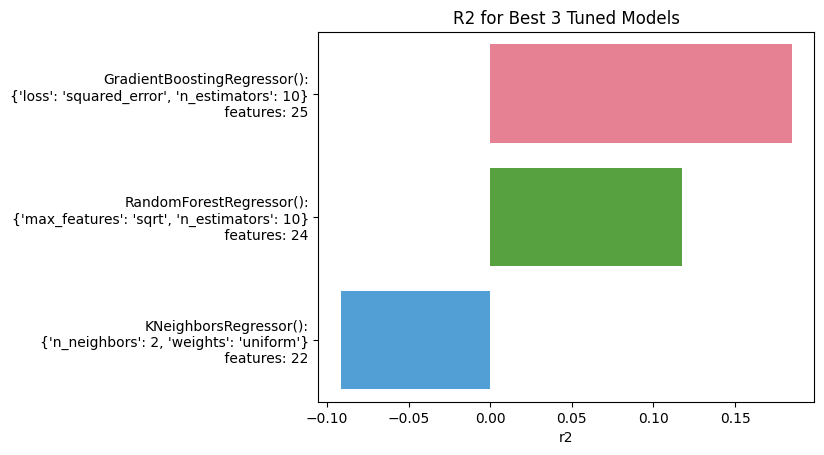

In [12]:
#r2 for best tuned models
sns.barplot(y= tuned_stats['summary'], x = tuned_stats['r2'], palette = sns.color_palette('husl',3))
plt.ylabel('')
plt.title("R2 for Best 3 Tuned Models")
plt.savefig('figures/r2_tuned_no_grades.png', dpi = 300, bbox_inches='tight')

/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_57119/4138945159.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
/var/folders/03/ncpt0f556jn9mwpykfyp_0rr0000gn/T/ipykernel_57119/4138945159.py:14: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))


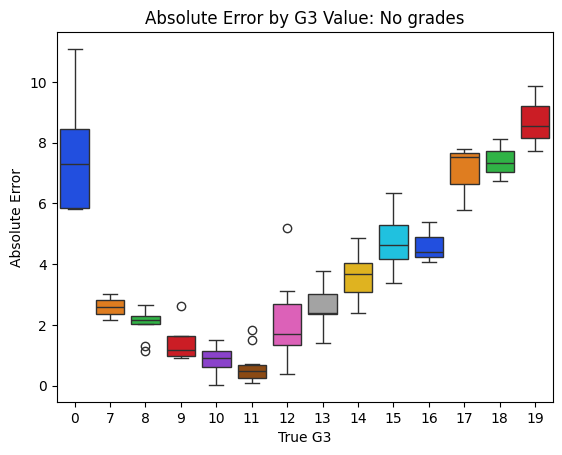

In [13]:
#Using best model, look at which values are most difficult to predict 
gb = GradientBoostingRegressor(n_estimators=10, loss = 'squared_error')
features = tuned_stats.iloc[2]['features']

gb.fit(X_train[features], y_train)
pred = gb.predict(X_test[features])

errors = [abs(pred[i]-list(y_test)[i]) for i in range(len(pred))]
df = pd.DataFrame()
df['true'] = y_test
df['error'] = errors


sns.boxplot(data = df, x = 'true', y = 'error', palette= sns.color_palette('bright', 20))
plt.title("Absolute Error by G3 Value: No grades")
plt.xlabel('True G3')
plt.ylabel("Absolute Error")
plt.savefig('figures/error_vs_true_no_grades.png', bbox_inches="tight")